# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep =';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(azdias.head())

print(feat_info.shape)
print(feat_info.head())

(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                  

In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,FINANZ_HAUSBAUER,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
col_names = azdias.columns
print(type(col_names))
# feat_info.set_index('attribute',inplace = True)
feat_info.head()

<class 'pandas.core.indexes.base.Index'>


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
#Step Takes a lot of time
# for column in col_names:
#     azdias[column] = azdias[column].map(lambda x : np.nan if str(x) in feat_info.loc[column].missing_or_unknown else x)
# turn missing_or_unknown to list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan


In [8]:
azdias.to_csv('azdias_parsed_temp_v2.csv', sep = ';', index = False)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
azdias = pd.read_csv('azdias_parsed_temp_v2.csv', sep = ';')

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing = azdias.isnull().sum()
missing = (missing / azdias.shape[0]) * 100

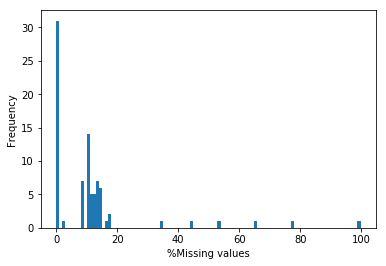

There are 61 columns with missing values out of 85 columns


In [21]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing, bins =100)
plt.xlabel('%Missing values')
plt.ylabel('Frequency')
plt.show()

print('There are {} columns with missing values out of {} columns'.format(sum((azdias.isnull().sum()) >0),len(col_names)))

In [22]:
missing.head()
#missing.index

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
dtype: float64

In [23]:
type(missing)

pandas.core.series.Series

In [24]:
#Remove the outlier columns from the dataset. (You'll perform other data
#engineering tasks such as re-encoding and imputation later.)
missing.sort_values(inplace = True)
missing = pd.DataFrame(missing)
missing.reset_index(inplace=True)

<BarContainer object of 85 artists>

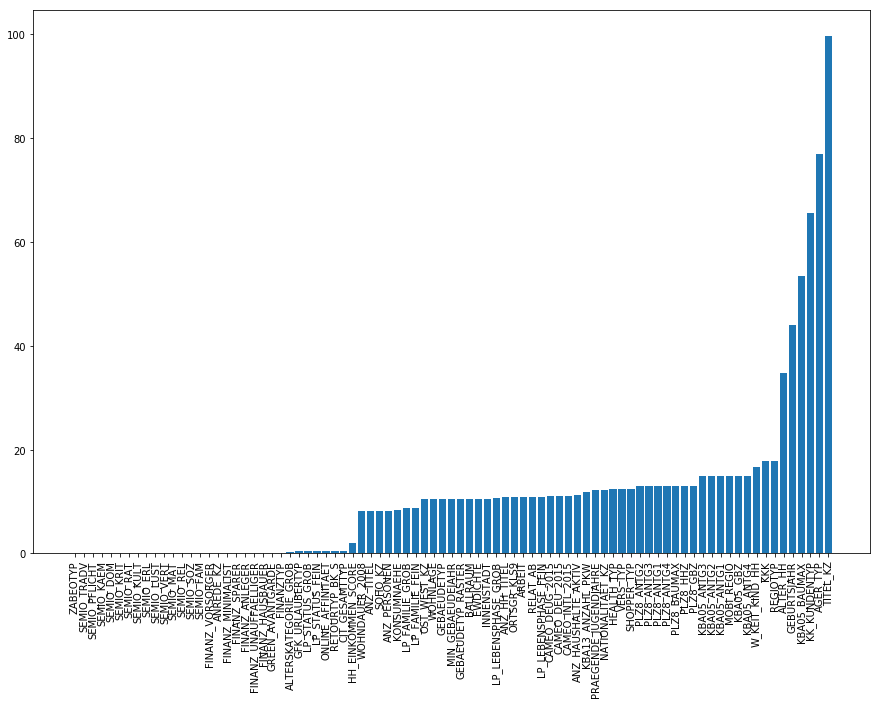

In [25]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
plt.bar(missing.iloc[:,0],missing.iloc[:,1])

In [26]:
cols_to_remove = []
for col in azdias.columns:
    if (azdias[col].isnull().sum()/azdias.shape[0])*100 > 20:
        cols_to_remove.append(col)

In [27]:
print(cols_to_remove)
len(cols_to_remove)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


6

In [28]:
for col in cols_to_remove:
    azdias.drop(col,axis=1, inplace = True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are 84 columns out of 85 which have missing values.
Majority of the colums have lesser than 20% of their values as missing values. Using this as the threshold, we can keep those columns with lesser than 20% missing values.

There are 12 columns with more than 20% missing values, in English they translate to: Best-ager typology, Gender, Financial typology, financial type, Year of birth, Health typology, Nationality based on given name analysis, Shopper typology, Insurance typology, Consumer pattern over past 12 months. Out of these features, except for Gender and Consumer Pattern over the past 12 months, the othr features are either indirectly covered in the other feaures or not that important.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull().sum(axis =1)
missing_rows = (missing_rows / azdias.shape[1]) * 100

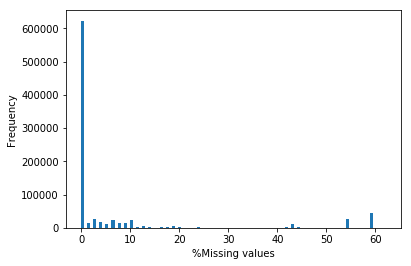

There are 268012 rows with missing values out of 891221 rows


In [30]:
plt.hist(missing_rows, bins =100)
plt.xlabel('%Missing values')
plt.ylabel('Frequency')
plt.show()

print('There are {} rows with missing values out of {} rows'.format(sum((azdias.isnull().sum(axis=1)) >0),azdias.shape[0]))

In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#Taking 10% missing values as the cutoff
missing_less = azdias[missing_rows <=10].reset_index(drop=True)
missing_more = azdias[missing_rows >10].reset_index(drop=True)


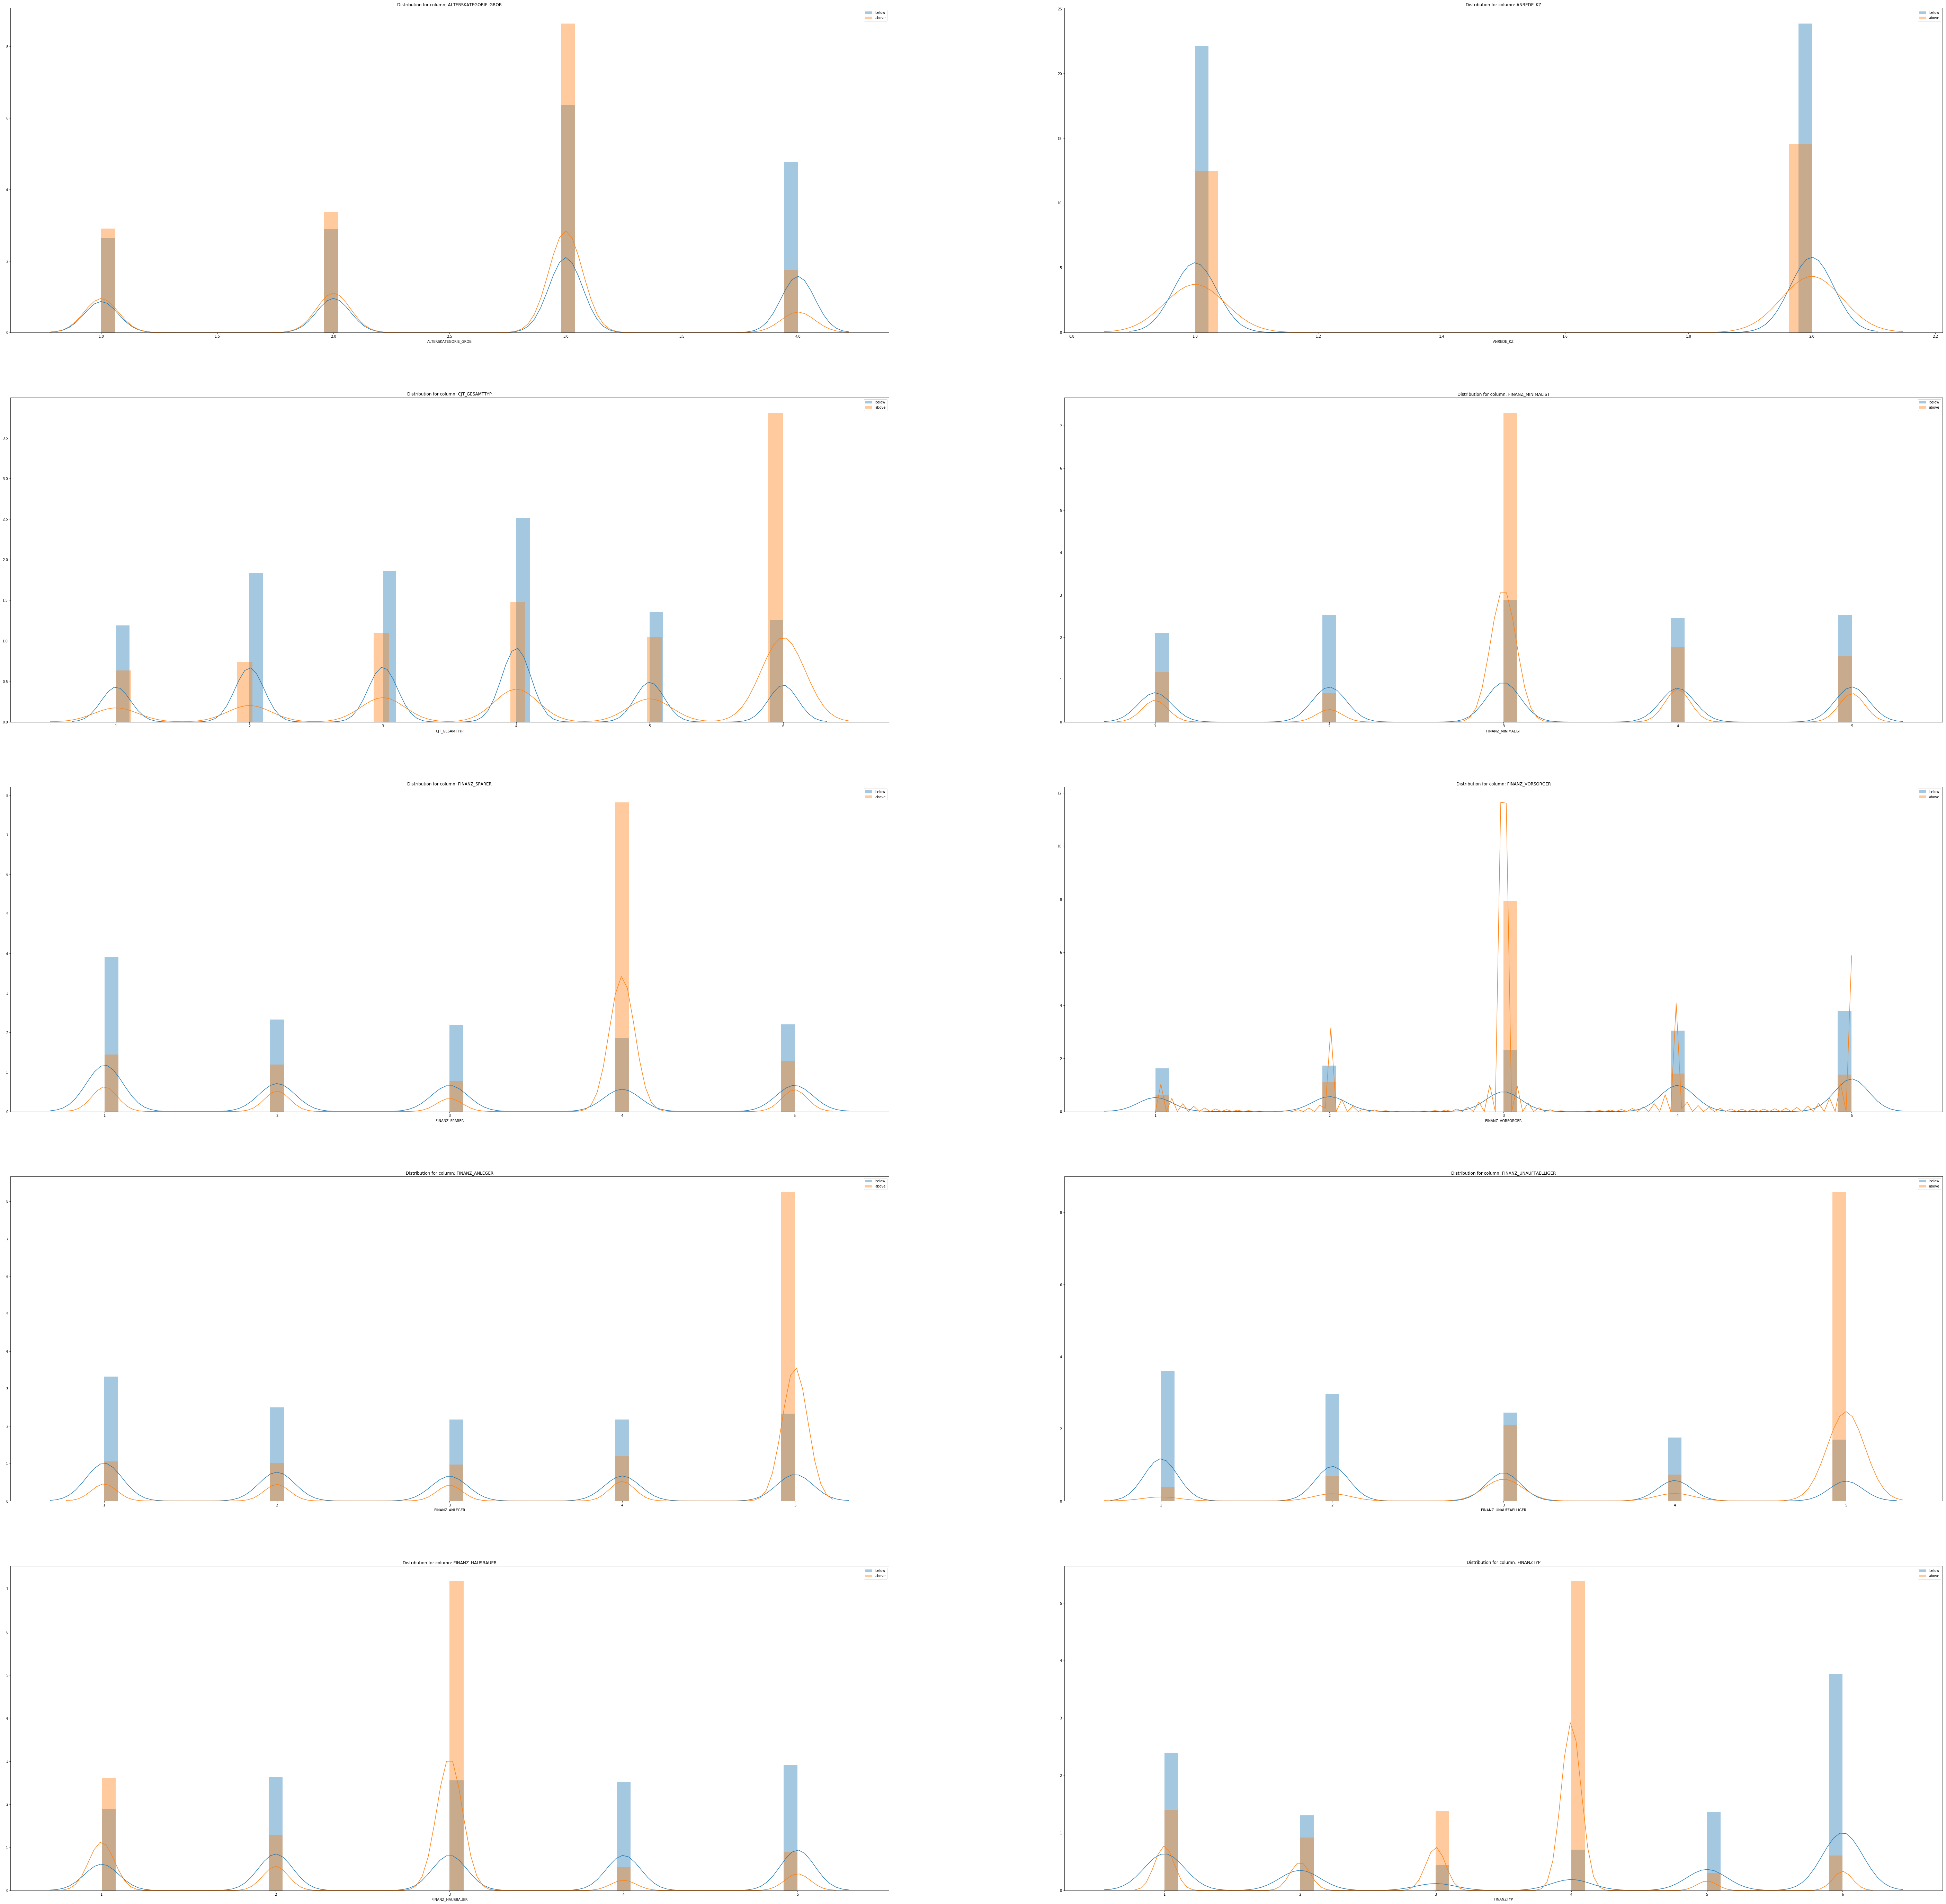

In [34]:
plt.figure(figsize=(100,100))
for i, col in enumerate(azdias.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(missing_less[col][missing_less[col].notnull()], label='below')
    sns.distplot(missing_more[col][missing_more[col].notnull()], label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

In [35]:
missing_less.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [36]:
missing_more.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,5.0,1.0,4.0,3.0,5.0,5.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0
3,3.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,2.0,4.0,4.0,1.0,5.0,1.0,1.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,5.0


In [37]:
print(missing_more.shape)
print(missing_less.shape)
missing_perc = (missing_more.shape[0]/azdias.shape[0])*100
print("%Rows with more than 10% missing values is {}".format(missing_perc))

(144112, 79)
(747109, 79)
%Rows with more than 10% missing values is 16.170175523242833


In [38]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
missing.head()


,index,0
0,ZABEOTYP,0.0
1,SEMIO_TRADV,0.0
2,SEMIO_PFLICHT,0.0
3,SEMIO_KAEM,0.0
4,SEMIO_DOM,0.0


In [39]:
#choosing the above mentioned 5 columns to check between the 2 datasets
cols_to_check = ['GREEN_AVANTGARDE','LP_STATUS_GROB','RETOURTYP_BK_S','ONLINE_AFFINITAET','LP_STATUS_FEIN']

In [40]:
#Plotting graphs to differentiate between the 2 datasets 
def plot_comparsion(df1,df2,col):
    fig, ax = plt.subplots(1,2)
    sns.countplot(df1[col],ax=ax[0])
    sns.countplot(df2[col],ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return


C:\Users\sp14657\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\sp14657\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\sp14657\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\sp14657\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get

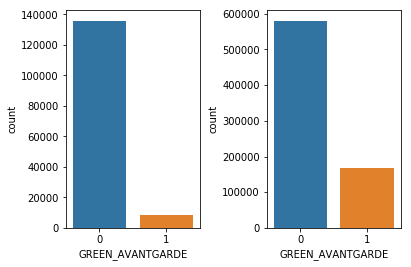

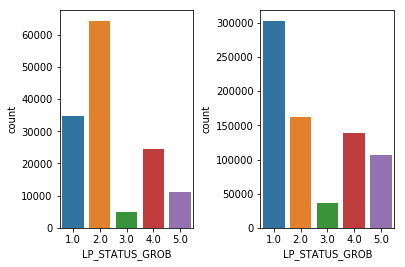

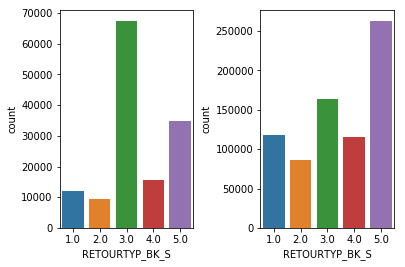

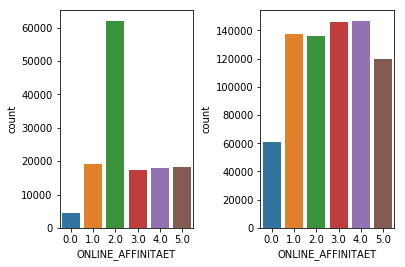

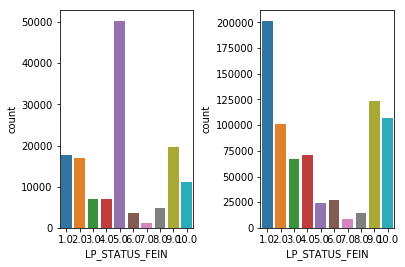

In [41]:
for col in cols_to_check:
    plot_comparsion(missing_more,missing_less,col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Looking at the histogram, we see that there is a normal distribution of the %missing values with a very long right tail. We choose the cutoff as 10% as this is where the long right tail begins. There are 798372 rows with missing values out of 891221 rows (16.6%).

We pick the 5 columns with the least number of missing data. After seperating the main dataset into 2 separate datasets into one with more than 10% missing values (147,807 rows) and second with less than or equal to 10% missing values (743,414 rows), we plot and compare the graphs amongst the features.

From this we see that distributions for: LP_STATUS_GROB, RETOURTYP_BK_S, ONLINE_AFFINITAET, LP_STATUS_FEIN are different and for: green_avantgarde are similar.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [42]:
# How many features are there of each data type?

feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [43]:
feat_info.head()
feat_info.reset_index(inplace =True)
feat_info.groupby('type').count()[['attribute']]

,attribute
type,
categorical,21
interval,1
mixed,7
numeric,7
ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [45]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep =';')
feat_info.set_index(['attribute'], inplace=True)

In [46]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

for col in missing_less.columns:
    if feat_info.loc[col].type == 'categorical':
        print(col, missing_less[col].nunique(),missing_less[col].dtype)

ANREDE_KZ 2 float64
CJT_GESAMTTYP 6 float64
FINANZTYP 6 float64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 3 float64
SHOPPER_TYP 4 float64
SOHO_KZ 2 float64
VERS_TYP 2 float64
ZABEOTYP 6 float64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 9 float64
CAMEO_DEU_2015 44 object


In [47]:
#Extracting non-numerical binary values and all categorical variables with more than 2 values for encoding
categorical_cols = []
for col in missing_less.columns:
    if feat_info.loc[col].type == 'categorical':
        if (missing_less[col].nunique() == 2 ) & (missing_less[col].dtype == 'object'):
            categorical_cols.append(col)
        elif (missing_less[col].nunique() > 2 ):
            categorical_cols.append(col)

In [48]:
categorical_cols

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [55]:
# Re-encode categorical variable(s) to be kept in the analysis.
missing_less_2 = pd.get_dummies(missing_less,columns = categorical_cols)

In [56]:
print(missing_less.shape[1])
print(missing_less_2.shape[1])

79
195


In [57]:
list(missing_less_2.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PL

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 12 categorical columns which have non-numerical binary values or more than 2 values. Since we want to retain all our information, we will one hot encode these 12 columns. The total number of columns increased from 79 to 195.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [73]:
for col in missing_less.columns:
    if feat_info.loc[col].type == 'mixed':
        print(col, missing_less[col].nunique(),missing_less[col].dtype)

LP_LEBENSPHASE_FEIN 40 float64
LP_LEBENSPHASE_GROB 12 float64
PRAEGENDE_JUGENDJAHRE 15 float64
WOHNLAGE 8 float64
CAMEO_INTL_2015 21 float64
PLZ8_BAUMAX 5 float64


In [59]:
#Dropping the 5 mixed variables for simplification
mixed_cols_to_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
for col in mixed_cols_to_drop:
    missing_less_2.drop(col, axis=1,inplace = True)

In [60]:
missing_less_2.shape[1]

191

In [61]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#missing_less_2.groupby('PRAEGENDE_JUGENDJAHRE').count()
missing_less_2['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  9.,  6.,  4., nan,  5.,  2.,  1.,
       12., 13.,  7.])

In [62]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variable

def make_interval(x):
    if x in [1,2]:
        return 1
    if x in [3,4]:
        return 2
    if x in [5,6,7]:
        return 3
    if x in [8,9]:
        return 4
    if x in [10,11,12,13]:
        return 5
    if x in [14,15]:
        return 6

In [63]:
missing_less_2['decade'] = missing_less_2['PRAEGENDE_JUGENDJAHRE'].apply(make_interval)

In [64]:
missing_less_2['decade'].unique()

array([ 6.,  4.,  2.,  5.,  3., nan,  1.])

In [65]:
def make_movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1

In [66]:
missing_less_2['movement'] = missing_less_2['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)

In [67]:
missing_less_2['movement'].unique()

array([ 1.,  0., nan])

In [68]:
missing_less_2.drop('PRAEGENDE_JUGENDJAHRE',axis=1, inplace=True)

In [69]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def wealth(x):
    if x // 10 == 1:
        return 1 
    if x // 10 == 2:
        return 2
    if x // 10 == 3:
        return 3
    if x // 10 == 4:
        return 4
    if x // 10 == 5:
        return 5
    
def life_stage(x):
    if x % 10 == 1:
        return 1
    if x % 10 == 2:
        return 2
    if x % 10 == 3:
        return 3
    if x % 10 == 4:
        return 4
    if x % 10 == 5:
        return 5

In [70]:
missing_less_2['wealth'] = missing_less_2['CAMEO_INTL_2015'].apply(wealth)
missing_less_2['life_stage'] = missing_less_2['CAMEO_INTL_2015'].apply(life_stage)
missing_less_2.drop('CAMEO_INTL_2015',axis =1,inplace = True)

In [71]:
missing_less_2['wealth'].unique()

array([ 5.,  2.,  1.,  4.,  3., nan])

In [72]:
missing_less_2['life_stage'].unique()

array([ 1.,  4.,  2.,  3.,  5., nan])

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 6 features with mixed-value features. 2 features have been engineered to make 4 features and the original 2 have been dropeed. Apart from this, the other 4 features have been dropped as there aren't enough levels to disentangle different values.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [78]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

missing_less_2.shape

(747109, 193)

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [105]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep =';')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attrib] == value, attrib] = np.nan

    cols_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    for col in cols_to_remove:
        df.drop(col,axis=1, inplace = True)

    missing_rows = df.isnull().sum(axis =1)
    missing_rows = (missing_rows / df.shape[1]) * 100
    df_2 = df[missing_rows <=10].reset_index(drop=True)

    #Extracting non-numerical binary values and all categorical variables with more than 2 values for encoding

    categorical_cols = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

    df_2_2 = pd.get_dummies(df_2,columns = categorical_cols)

    mixed_cols_to_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
    for col in mixed_cols_to_drop:
        df_2_2.drop(col, axis=1,inplace = True)

    df_2_2['decade'] = df_2_2['PRAEGENDE_JUGENDJAHRE'].apply(make_interval)
    df_2_2['movement'] = df_2_2['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)
    df_2_2.drop('PRAEGENDE_JUGENDJAHRE',axis=1, inplace=True)

    df_2_2['wealth'] = df_2_2['CAMEO_INTL_2015'].apply(wealth)
    df_2_2['life_stage'] = df_2_2['CAMEO_INTL_2015'].apply(life_stage)
    df_2_2.drop('CAMEO_INTL_2015',axis =1,inplace = True)

    return df_2_2


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [79]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
missing_less_2
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(missing_less_2)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)

In [80]:
missing_less_2.isnull().sum()

ALTERSKATEGORIE_GROB      2469
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               24356
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                 24356
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
                         ...  
CAMEO_DEU_2015_5A            0
CAMEO_DE

In [81]:
missing_less_3 = imp_mean.fit_transform(missing_less_2)

In [82]:
type(missing_less_3)

numpy.ndarray

In [83]:
missing_less_3 = pd.DataFrame(missing_less_3,columns = missing_less_2.columns)

In [84]:
missing_less_3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,4.0


In [85]:
missing_less_3.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
                        ..
CAMEO_DEU_2015_5A        0
CAMEO_DEU_2015_5B        0
CAMEO_DEU_2015_5C        0
CAMEO_DEU_2015_5D        0
CAMEO_DEU_2015_5E        0
CAMEO_DEU_2015_5F        0
C

In [86]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
missing_less_4 = scaler.fit_transform(missing_less_3)


In [87]:
scaling_object = scaler.fit(missing_less_3)

In [88]:
missing_less_4 = pd.DataFrame(missing_less_4, columns = missing_less_3.columns)

In [89]:
missing_less_4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage
0,-1.754918,0.962859,-1.503661,1.559941,-1.049535,1.490708,1.013168,1.331159,-0.536372,1.013071,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,-0.087052,1.123587,0.536372,1.164584,-1.249676
1,0.198237,0.962859,-1.503661,0.884836,-1.773085,-0.555630,0.291141,1.331159,1.864378,1.013071,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,-0.087052,1.123587,-1.864378,-0.880212,0.758861
2,1.174815,0.962859,0.685685,-0.465374,1.121117,-0.555630,-1.152912,-0.831846,-0.536372,-0.309433,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,-0.087052,-0.241508,0.536372,-1.561811,-0.580164
3,0.198237,-1.038573,0.685685,0.209731,0.397566,-1.237743,0.291141,-0.831846,-0.536372,1.013071,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,-0.087052,-0.241508,0.536372,0.482985,0.089348
4,-1.754918,0.962859,-0.044097,-1.140479,1.121117,-0.555630,-0.430886,1.331159,-0.536372,1.013071,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,-0.087052,-1.606603,0.536372,1.164584,0.758861


### Discussion 2.1: Apply Feature Scaling

We have imputed the missing values using the most frequent value in each column.
For each column, we have used it by performing transformation. Ie. Standardizing features by removing the mean and scaling to unit variance

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [90]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
missing_less_4_PCA = pca.fit_transform(missing_less_4)


In [91]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    


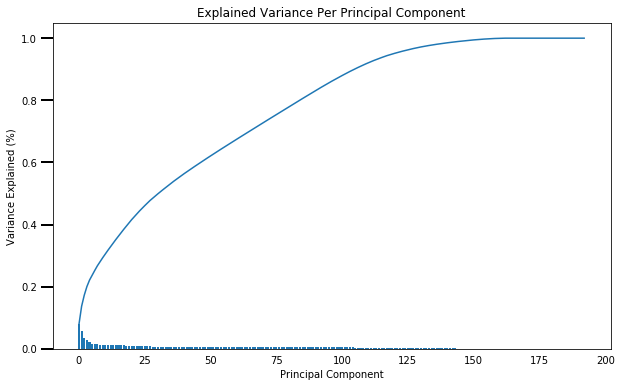

In [92]:
scree_plot(pca)

In [93]:
# Re-apply PCA to the data while selecting for number of components to retain.
##Check
pca = PCA(n_components = 100)
missing_less_4_PCA = pca.fit_transform(missing_less_4)

In [94]:
pca_object = pca.fit(missing_less_4)

### 2.2: Perform Dimensionality Reduction

By looking at the above plot, we see that after 100 features, the variance explained levels off and the cumulative explained is around 0.9 at the 100 features mark. So I choose 100 features to re-do the PCA.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [95]:
pca.components_.shape

(100, 193)

In [96]:
def pca_weights(pca,i):
    df = pd.DataFrame(pca.components_, columns = missing_less_4.columns)
    weights = df.iloc[i].sort_values(ascending = False)
    return weights

In [97]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_weight_0 = pca_weights(pca,0)
print(pca_weight_0)

LP_STATUS_GROB_1.0      0.195592
HH_EINKOMMEN_SCORE      0.185103
wealth                  0.184240
PLZ8_ANTG3              0.181280
PLZ8_ANTG4              0.175543
ORTSGR_KLS9             0.152451
EWDICHTE                0.150383
FINANZ_HAUSBAUER        0.145454
KBA05_ANTG4             0.128139
LP_STATUS_FEIN_1.0      0.127283
PLZ8_ANTG2              0.123081
FINANZ_SPARER           0.120032
KBA05_ANTG3             0.116870
LP_STATUS_FEIN_2.0      0.115475
ANZ_HAUSHALTE_AKTIV     0.115133
FINANZTYP_1.0           0.113918
ARBEIT                  0.113787
CAMEO_DEUG_2015_9.0     0.113288
movement                0.107869
RELAT_AB                0.105567
CAMEO_DEUG_2015_8.0     0.091540
SEMIO_PFLICHT           0.087464
decade                  0.084091
LP_FAMILIE_FEIN_1.0     0.083919
LP_FAMILIE_GROB_1.0     0.083919
SEMIO_REL               0.082552
ZABEOTYP_5.0            0.079944
SEMIO_RAT               0.074644
SEMIO_TRADV             0.067565
GEBAEUDETYP_3.0         0.066032
          

In [98]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_1 = pca_weights(pca,1)
print(pca_weight_1)


ALTERSKATEGORIE_GROB     0.230380
FINANZ_VORSORGER         0.214492
ZABEOTYP_3.0             0.200203
SEMIO_ERL                0.180498
SEMIO_LUST               0.160803
RETOURTYP_BK_S           0.157884
W_KEIT_KIND_HH           0.123223
CJT_GESAMTTYP_2.0        0.105723
LP_STATUS_FEIN_1.0       0.101674
FINANZTYP_5.0            0.095862
FINANZ_HAUSBAUER         0.090495
FINANZTYP_2.0            0.086462
FINANZ_MINIMALIST        0.081595
SHOPPER_TYP_3.0          0.077748
SEMIO_KRIT               0.077309
PLZ8_ANTG3               0.073018
CJT_GESAMTTYP_1.0        0.069645
PLZ8_ANTG4               0.069412
EWDICHTE                 0.068911
ORTSGR_KLS9              0.068190
FINANZTYP_6.0            0.065874
NATIONALITAET_KZ_1.0     0.064451
wealth                   0.064250
LP_FAMILIE_GROB_1.0      0.063301
LP_FAMILIE_FEIN_1.0      0.063301
SEMIO_KAEM               0.059697
GFK_URLAUBERTYP_4.0      0.058774
KBA05_ANTG4              0.056508
ARBEIT                   0.053634
WOHNDAUER_2008

In [99]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_2 = pca_weights(pca,2)
print(pca_weight_2)

SEMIO_VERT               0.320294
SEMIO_FAM                0.259984
SEMIO_SOZ                0.257367
SEMIO_KULT               0.247839
FINANZTYP_5.0            0.137491
FINANZ_MINIMALIST        0.129223
SHOPPER_TYP_0.0          0.123011
SEMIO_REL                0.116328
ZABEOTYP_1.0             0.116076
SEMIO_MAT                0.086236
RETOURTYP_BK_S           0.079531
GREEN_AVANTGARDE         0.078429
EWDICHTE                 0.066079
ORTSGR_KLS9              0.065698
W_KEIT_KIND_HH           0.065698
LP_STATUS_GROB_5.0       0.055480
LP_STATUS_FEIN_10.0      0.055480
PLZ8_ANTG4               0.050082
PLZ8_ANTG3               0.049898
ZABEOTYP_6.0             0.049702
FINANZ_VORSORGER         0.046762
SHOPPER_TYP_1.0          0.046121
LP_STATUS_FEIN_3.0       0.045376
LP_STATUS_FEIN_1.0       0.043753
PLZ8_ANTG2               0.036811
RELAT_AB                 0.035411
ARBEIT                   0.032607
LP_STATUS_GROB_3.0       0.032359
GEBAEUDETYP_3.0          0.031392
NATIONALITAET_

### Discussion 2.3: Interpret Principal Components

#### 1st Principal Component
4 Most Positive Features: LP_STATUS_GROB_1.0, wealth, HH_EINKOMMEN_SCORE (Social Status- Low Income Earners, wealth, Estimated household net income)

3 Most Negative Features: FINANZ_MINIMALIST, KBA05_ANTG1, MOBI_REGIO (XX, Number of 1-2 family houses in the microcell, Movement patterns)

Whenever social status - low income earners is 1 then then the person is going to earn less which is directly proportional to the coefficient of wealth which is correct ( the higher the value of the wealth feature, the lower the income bracket the person belongs to). This applies to Estimated household net income in the same way - the higher the value, the lesser the income.
Wealth and earnings features are inversely proportional to low financial coefficients which is also correct since lesser income is coming out to be inversely proportional to more financial interest.


#### 2nd Principal Component
3 Most Positive Features: ALTERSKATEGORIE_GROB, ZABEOTYP_3.0, FINANZ_VORSORGER  (Estimated age based on given name analysis (higher the elder), Energy consumption typology - fair supplied, Be prepared financial topology)

3 Most Negative Features: decade, SEMIO_REL, FINANZ_SPARER (generation decade, Personality typology - religious, Money-Saver financial topology)

Whenever the age feature would be more, the decade should be less which is being reflected by the coefficients. 

#### 3rd Principal Component
3 Most Positive Features: SEMIO_SOZ, SEMIO_FAM, SEMIO_VERT (Personality typology -socially-minded ,Personality typology - family-minded, Personality typology - dreamful)

3 Most Negative Features: SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT (Personality typology - combative attitude, Personality typology - dominant-minded, Personality typology - critical-minded)

Combative, dominant and critical all go hand-in-hand which is relected by the coeffcients. Also, if a person is family - minded, there's a high probability that he will also be socially-minded which is also reflected by the coefficients.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [100]:
from sklearn.cluster import KMeans

def k_means_Score(data,no_clusters):
    kmeans = KMeans(n_clusters = no_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [101]:
# Over a number of different cluster counts...

scores = []
for i in range(1,15):
    scores.append(k_means_Score(missing_less_4_PCA,i))

Text(0, 0.5, 'Score')

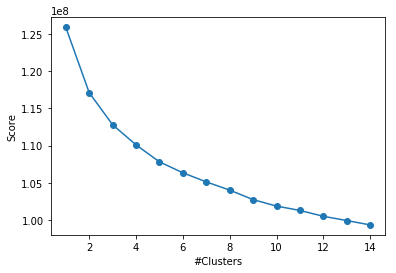

In [102]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(1,15),scores, linestyle = '-',marker= 'o')
plt.xlabel('#Clusters')
plt.ylabel('Score')

In [103]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 10)
model_kmeans_k_10 = kmeans.fit(missing_less_4_PCA)
model_kmeans_k_10.predict(missing_less_4_PCA)

array([5, 8, 6, ..., 8, 2, 0])

In [104]:
missing_less_4_PCA_predict = model_kmeans_k_10.predict(missing_less_4_PCA)

### Discussion 3.1: Apply Clustering to General Population

From the above plot, if one had to choose an elbow- 10 appears to be the value at which the graph starts stabilizing. Hence choosing k = 10 as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [106]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset - Copy.csv')

In [107]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [108]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

C:\Users\sp14657\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [ ]:
# customers['CAMEO_INTL_2015'].unique()
# customers['CAMEO_INTL_2015'].apply(wealth)


In [109]:
customers_clean.head()
customers_clean.shape

(133427, 192)

In [110]:
customers_clean.to_csv('customers_clean_temp.csv')

In [114]:
customers_clean = pd.read_csv('customers_clean_temp - Copy.csv')

In [116]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
customers_clean.isnull().sum()

ALTERSKATEGORIE_GROB      203
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
GREEN_AVANTGARDE            0
HEALTH_TYP               1894
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
SOHO_KZ                     0
VERS_TYP                 1894
ANZ_PERSONEN                0
ANZ_TITEL                   0
HH_EINKOMMEN_SCORE          0
                         ... 
CAMEO_DEU_2015_5B           0
CAMEO_DEU_2015_5C           0
CAMEO_DEU_

In [117]:
#Replacing Nan's
customers_clean_2 = imp_mean.transform(customers_clean)
customers_clean_2 = pd.DataFrame(customers_clean_2,columns = customers_clean.columns)
customers_clean_2.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
                        ..
CAMEO_DEU_2015_5B        0
CAMEO_DEU_2015_5C        0
CAMEO_DEU_2015_5D        0
CAMEO_DEU_2015_5E        0
CAMEO_DEU_2015_5F        0
CAMEO_DEU_2015_6A        0
C

In [118]:
#Scaling
customers_clean_3 = scaling_object.transform(customers_clean_2)
customers_clean_3 = pd.DataFrame(customers_clean_3, columns = customers_clean_2.columns)

customers_clean_3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,life_stage,GEBAEUDETYP_5.0
0,1.174815,-1.038573,1.415467,-1.140479,1.121117,-1.237743,-0.430886,-0.831846,1.864378,-1.631938,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,23.061925,-2.971698,0.536372,-0.198614,-1.919188
1,1.174815,0.962859,1.415467,-1.140479,1.121117,-1.237743,1.013168,0.610157,1.864378,-0.309433,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,23.061925,-2.971698,5.337871,0.482985,-1.919188
2,1.174815,-1.038573,1.415467,-1.140479,1.121117,-0.555630,-1.152912,-0.831846,-0.536372,-0.309433,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,11.487437,-2.289151,2.937122,0.482985,-1.919188
3,0.198237,-1.038573,-0.044097,-1.140479,0.397566,0.808596,1.735195,-0.831846,-0.536372,1.013071,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,46.210902,-2.289151,7.738621,-1.561811,-1.919188
4,0.198237,-1.038573,1.415467,-1.140479,1.121117,-1.237743,-0.430886,-0.110844,1.864378,1.013071,...,-0.152876,-0.164254,-0.19162,-0.180623,-0.195966,23.061925,-2.971698,5.337871,0.482985,-1.919188


In [119]:
customers_clean_3.to_csv('customers_clean_3_temp.csv')

In [120]:
#customers_clean_3 = pd.read_csv('customers_clean_3.csv')

In [121]:
##PCA
customers_clean_3_PCA = pca_object.transform(customers_clean_3)

In [122]:
model_kmeans_k_10.predict(customers_clean_3_PCA)

array([7, 1, 6, ..., 7, 1, 6])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [123]:
np.unique(model_kmeans_k_10.predict(customers_clean_3_PCA))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [124]:
np.unique(model_kmeans_k_10.predict(missing_less_4_PCA))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [125]:
missing_less_4_PCA_predict = model_kmeans_k_10.predict(missing_less_4_PCA)
customers_clean_3_PCA_predict = model_kmeans_k_10.predict(customers_clean_3_PCA)

In [126]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_prop = []
x = [i+1 for i in range(10)]
for i in range(10):
    general_pop.append((missing_less_4_PCA_predict == i).sum()/len(missing_less_4_PCA_predict))
    customers_prop.append((customers_clean_3_PCA_predict == i).sum()/len(customers_clean_3_PCA_predict))

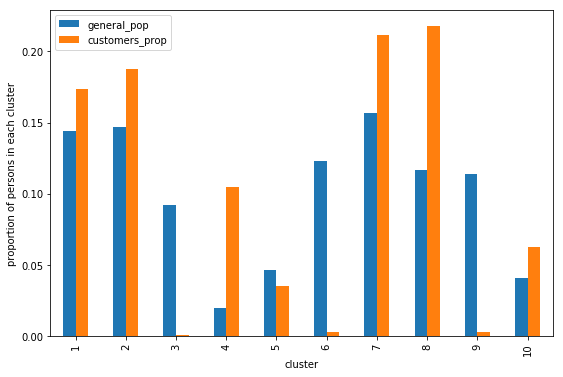

In [127]:
# plt.plot(x,general_pop, color='green', marker='o', linestyle='dashed')
# plt.plot(x,customers_prop, color='orange', marker='o', linestyle='dashed')

df_pop = pd.DataFrame({'cluster':x,'general_pop':general_pop,'customers_prop':customers_prop})
df_pop.plot(x='cluster',y=['general_pop','customers_prop'],kind='bar',figsize = (9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [128]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Clusters which are overrepresented in the customer data compared to the general population are: 1,2,4,7,8,10
#Cluster where the difference is the most is : Cluster 4

customers_clean_2['cluster'] = customers_clean_3_PCA_predict
missing_less_3['cluster'] = missing_less_4_PCA_predict

In [129]:
print(customers_clean_2.shape)
customers_clean_2_cluster_4 = customers_clean_2[customers_clean_2['cluster']==4]
print(customers_clean_2_cluster_4.shape)

(133427, 194)
(4676, 194)


In [133]:
cols_to_compare = ['LP_STATUS_GROB_1.0','wealth','PLZ8_ANTG3','PLZ8_ANTG1','KBA05_ANTG1','MOBI_REGIO','ALTERSKATEGORIE_GROB','ZABEOTYP_3.0','SEMIO_LUST','decade','SEMIO_REL','SEMIO_PFLICHT','SEMIO_KAEM','SEMIO_DOM','SEMIO_KRIT','SEMIO_SOZ','SEMIO_FAM','SEMIO_VERT','RETOURTYP_BK_S','FINANZ_MINIMALIST','FINANZ_VORSORGER','FINANZ_HAUSBAUER','wealth','life_stage',]

In [134]:
def plot_comparsion(df1,df2,col):
    fig, ax = plt.subplots(1,2)
    sns.countplot(df1[col],ax=ax[0])
    sns.countplot(df2[col],ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return


In [135]:
import warnings
warnings.filterwarnings('ignore')

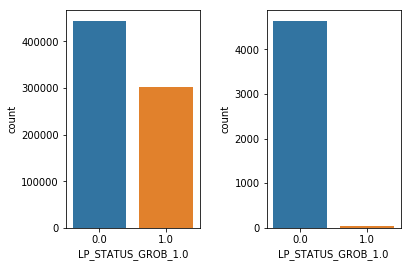

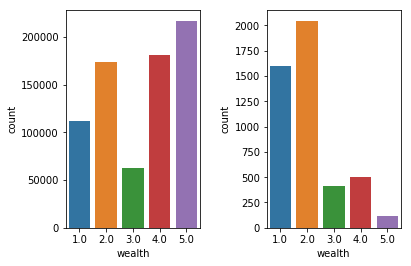

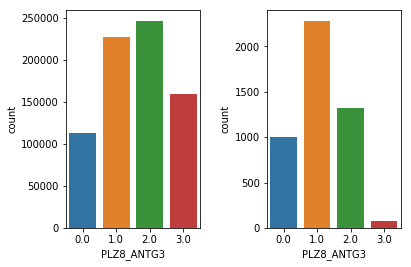

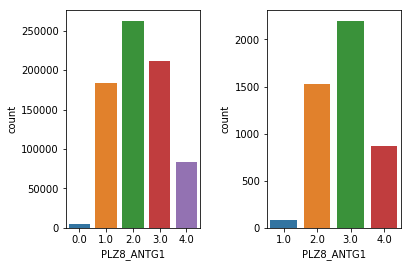

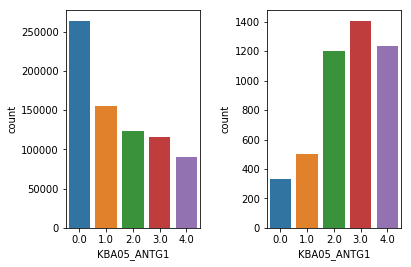

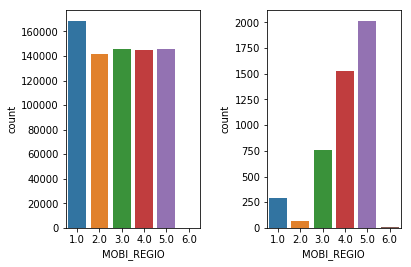

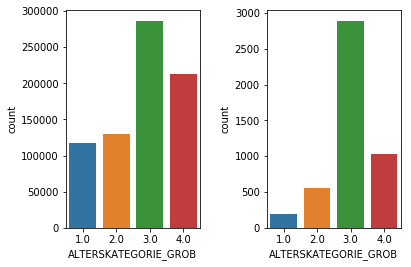

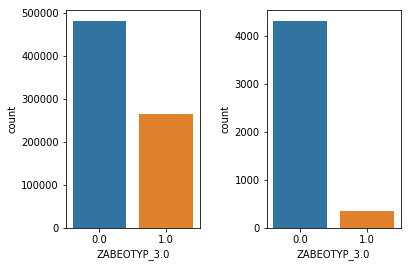

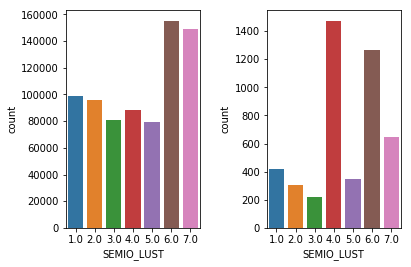

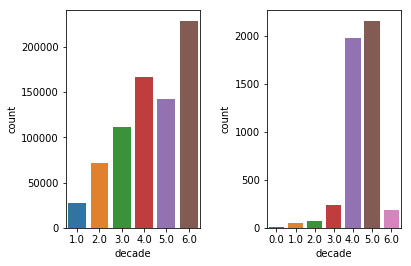

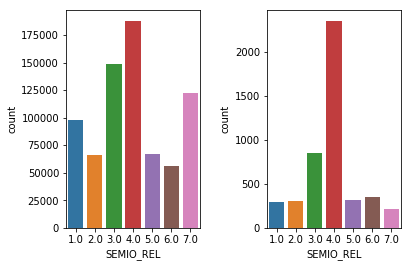

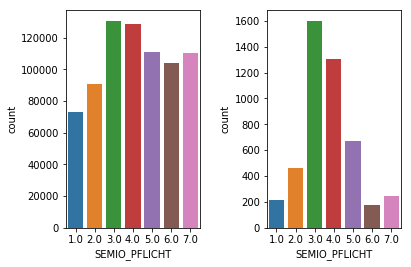

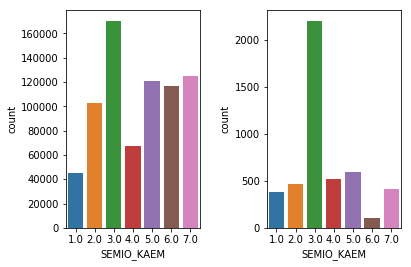

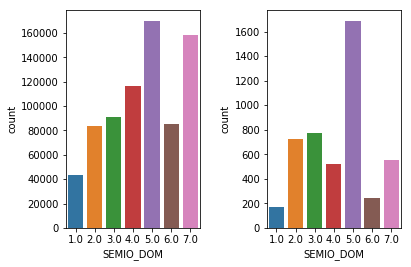

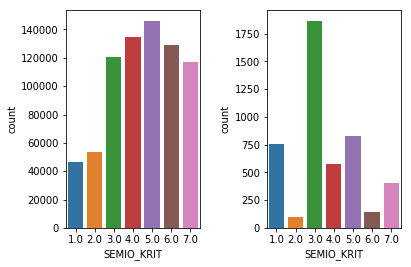

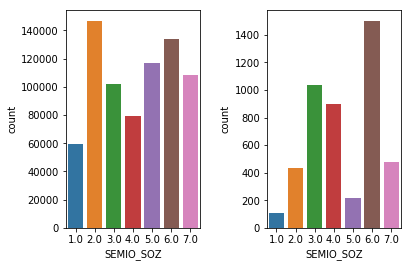

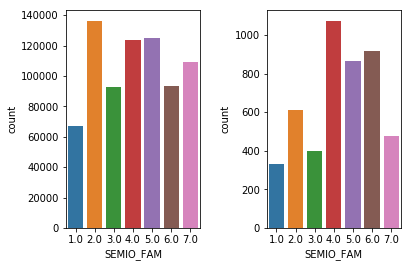

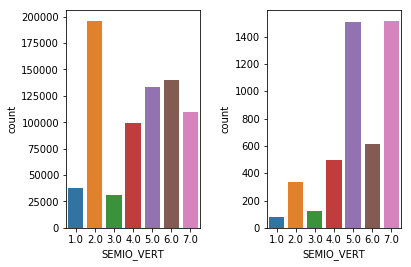

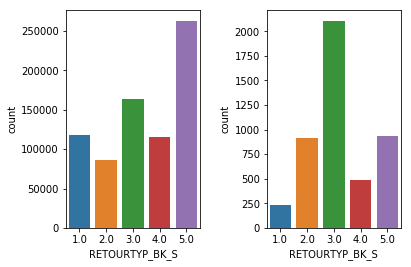

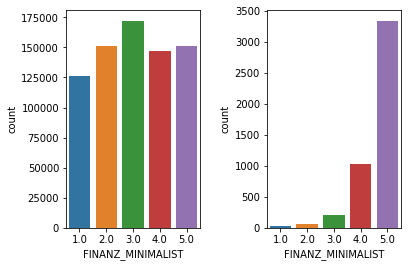

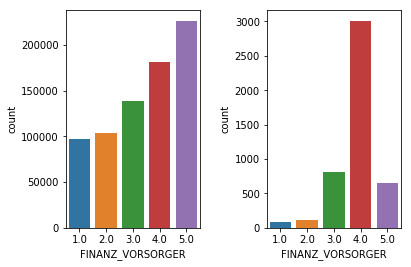

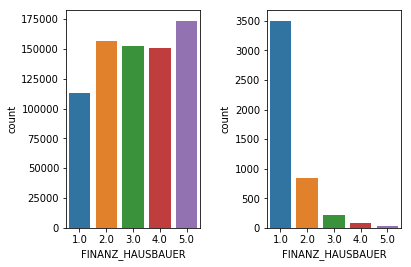

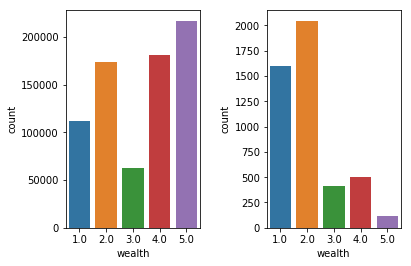

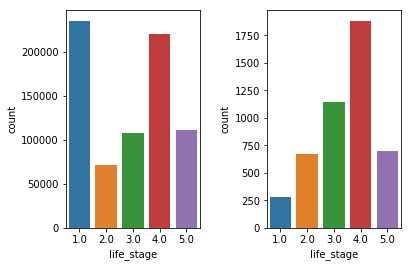

In [136]:
for col in cols_to_compare:
    plot_comparsion(missing_less_3,customers_clean_2_cluster_4,col)

In [137]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Clusters which are underrepresented in the customer data compared to the general population are:  3,5,6,9
# Cluster where the difference is the most is : Cluster 6

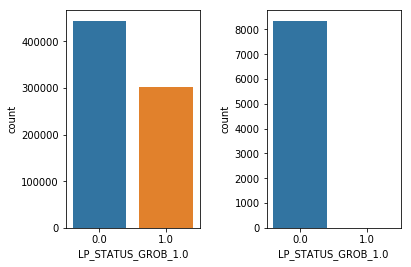

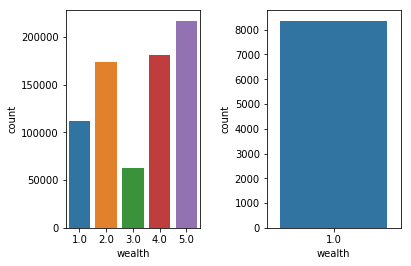

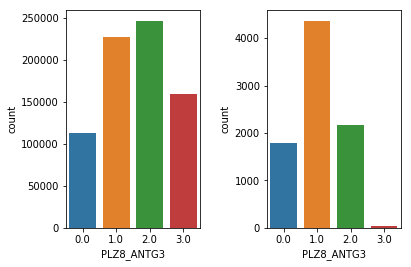

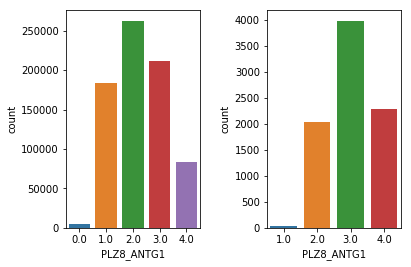

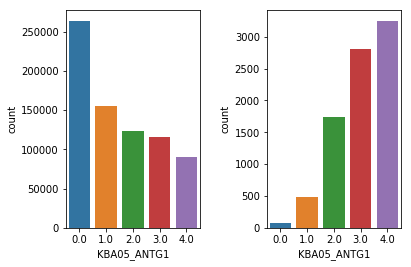

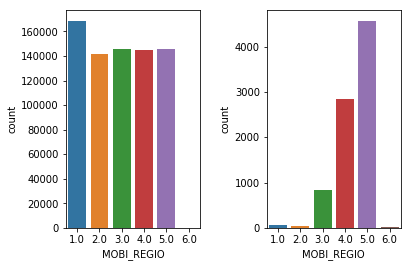

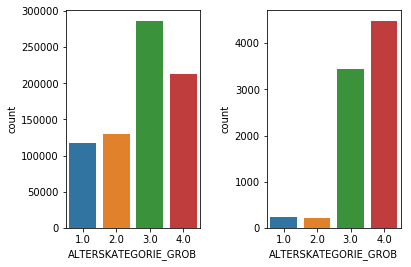

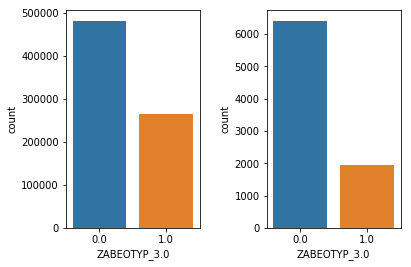

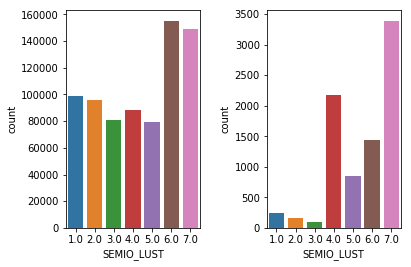

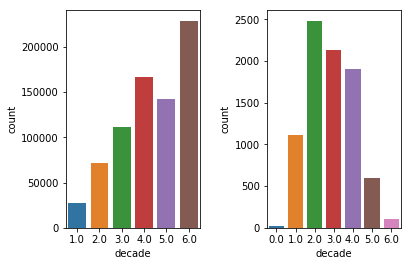

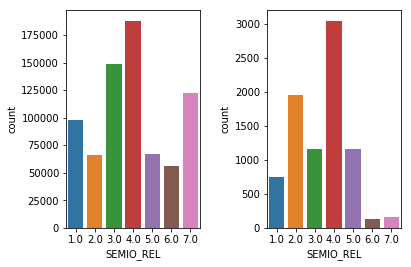

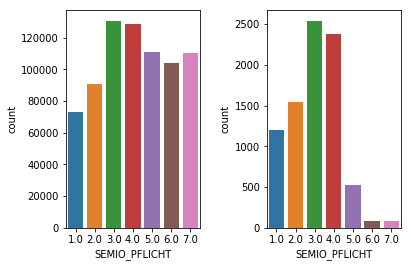

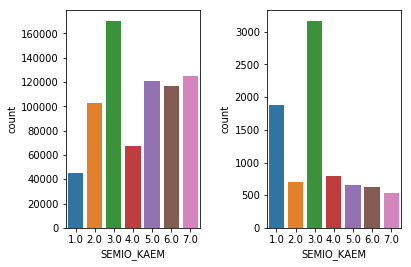

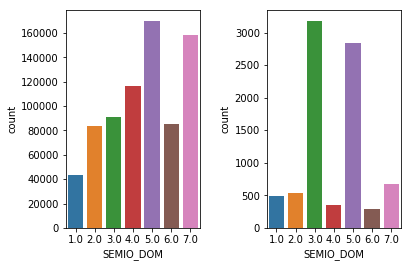

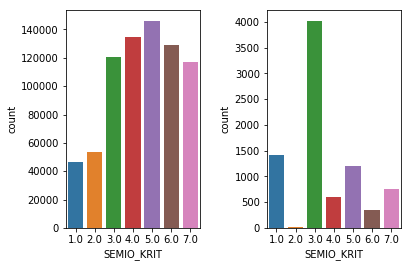

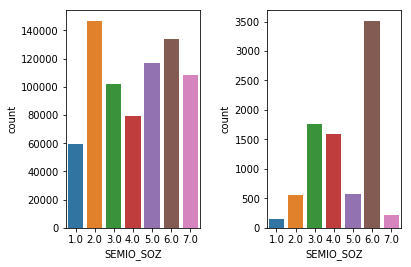

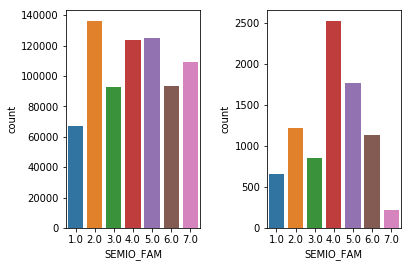

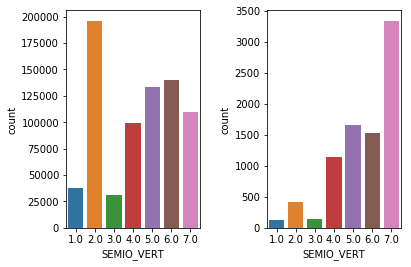

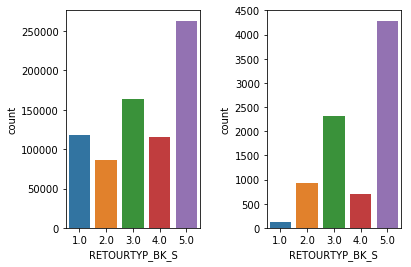

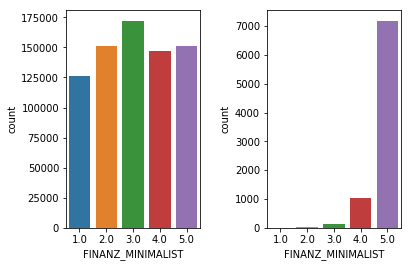

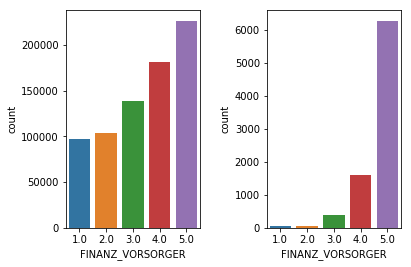

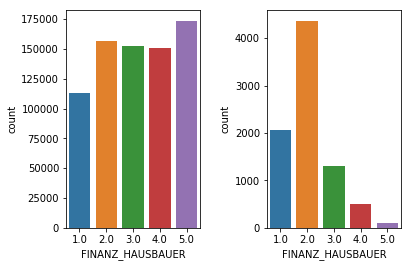

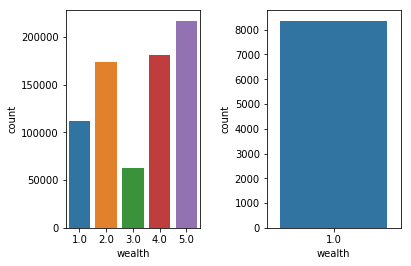

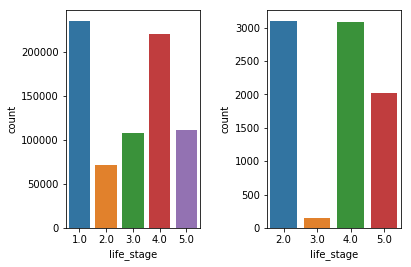

In [140]:
customers_clean_2_cluster_9 = customers_clean_2[customers_clean_2['cluster']==9]
for col in cols_to_compare:
    plot_comparsion(missing_less_3,customers_clean_2_cluster_9,col)

### Discussion 3.3: Compare Customer Data to Demographics Data

Example of Segment of Population that are relatively popular with the mail-order company: Cluster 4

Attributes of this segment are- 
low income owners
RR4 micro-cell- Comfortable to prosperous households
Low to average number of 6-10 family houses in the PLZ8 region
High share of 1-2 family homes
Very low movement
High purchasing power in region
70's and 80's - primary dominating movement of person's youth
Low affinity to being dominant minded
High affinity to being critical minded
very low affinity to being dreamful
Influenceable crazy shopper and heavy-normal returners
Very low - low financial interest
Low - Be prepared financial typology
Very high home ownership
Wealthy and Prspoerous households

Example of Segment of Population that are relatively unpopular with the mail-order company: Cluster 6

low income owners
RR4 micro-cell- Prosperous households
Low to average number of 6-10 family houses in the PLZ8 region
Average to high number of 1-2 family houses in the PLZ8 region
Average share of 1-2 family homes
Low movement
Elderly population (40-60)
40s-60s - Primary Dominating movement of person's youth
High affinity to religious
High affinity to dutiful
High affinity to combative attitude
High affinity to dominant-minded
High affinity to critical-minded
High affinity to family-minded
low affinity to being dreamful
Very low - low financial interest
Very low home ownership

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.